In [5]:
cur_date = "071522"

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)
library(RColorBrewer)
library(patchwork)

# reading in file
allostatic_loading_df = data.frame(read_excel("Input/Allostatic_Mediator_Data_061722ap.xlsx", sheet = 2))

In [6]:
head(allostatic_loading_df)

,Study,Original_Subject_Number,Subject_Number,Group,Subject_ID,Sex,Age,Race,Category,Variable,Value
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1,FM2,97,1,CS,CS_1,M,18,B,AL Biomarker,Cortisol,140.304
2,FM2,99,2,CS,CS_2,F,20,W,AL Biomarker,Cortisol,246.542
3,FM2,101,3,CS,CS_3,F,20,W,AL Biomarker,Cortisol,50.878
4,FM2,98,4,CS,CS_4,F,21,W,AL Biomarker,Cortisol,137.387
5,TCORS LAIV,39,5,CS,CS_5,M,21,W,AL Biomarker,Cortisol,116.602
6,FM2,100,6,CS,CS_6,F,22,W,AL Biomarker,Cortisol,54.030


Using Principal Component Analysis (PCA) to determine which mediators potentially drive altered cytokine expression. 

In [7]:
cytokine_df = allostatic_loading_df %>%
    filter(Category == "Cytokine") %>%
    pivot_wider(names_from = Variable, values_from = Value) %>%
    column_to_rownames(var = "Subject_ID")

# removing uneeded cols
cytokine_pca_prep_df = cytokine_df[,9:19]

head(cytokine_pca_prep_df)

,IP10,IFNg,IL10,IL12p70,IL13,IL1B,IL2,IL4,IL6,IL8,TNFa
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CS_1,0.0990,8.934312,1.0295220,76.87931,71.06668,0.103931342,8020.5883,0.05284668,0.9701685,40.793059,1.4034574
CS_2,0.3560,40.776028,2.6620592,112.87463,133.50995,0.175212625,2129.6754,0.16376793,1.6930344,44.139716,2.6867365
CS_3,0.2140,9.669022,0.4610488,100.37526,84.42035,0.158904987,2193.8494,0.06684738,2.3449499,38.192519,2.7733909
CS_4,0.0840,34.828043,1.0133070,78.09485,174.74692,0.623641689,3181.0656,0.20181912,5.0223231,40.306732,2.4928552
CS_5,123.0310,1.843052,0.3628385,48.39125,28.52424,0.000697524,757.2486,0.04107563,0.2261411,9.689276,0.8559537
CS_6,0.1075,15.608958,0.6512180,79.33985,73.53211,0.083513359,1825.6259,0.06245179,0.7972528,22.205037,2.0680960


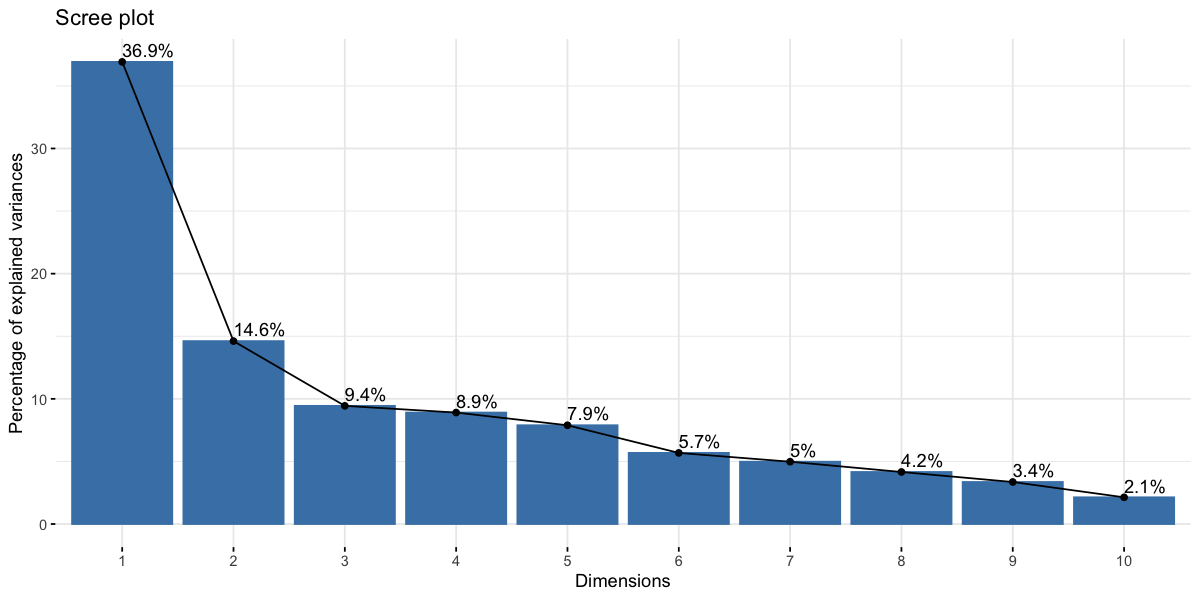

In [8]:
# running PCA
pca_cytokine = prcomp(cytokine_pca_prep_df, scale = TRUE)

# viewing scree plots to see how much of the variance was captured in first 2 eigenvectors
options(repr.plot.width=10, repr.plot.height=5) #changing size
fviz_eig(pca_cytokine, addlabels = TRUE)

Warning message:
“ggrepel: 45 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


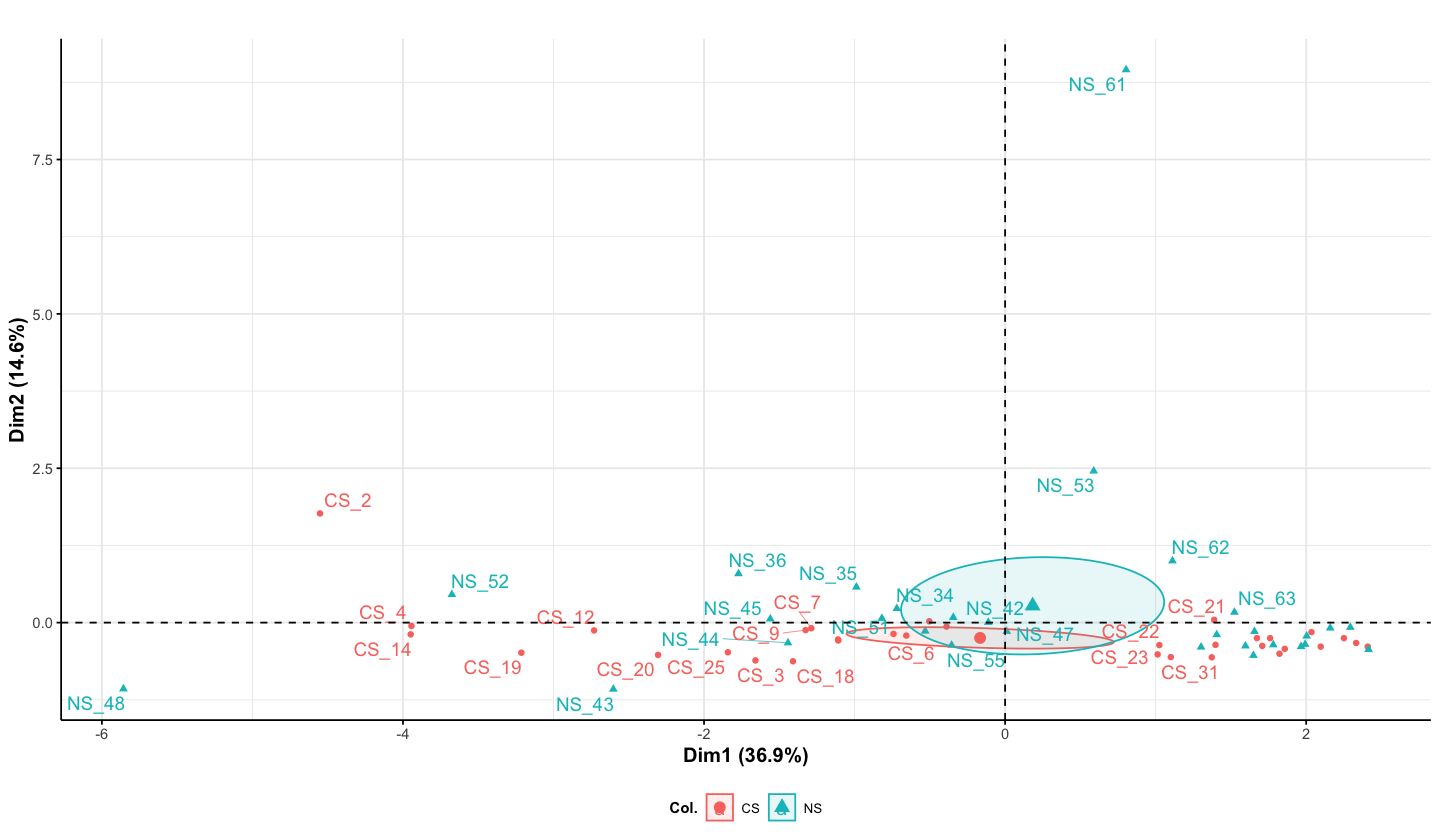

In [9]:
# visualizing all data to detect outlier subjects
options(repr.plot.width=12, repr.plot.height=7) #changing size
fviz_pca_ind(pca_cytokine, 
             col.ind = cytokine_df$Group, # color by Group
             #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.title = element_text(size = 9, face = "bold"),
      legend.text = element_text(size = 8),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.1))) #changes axis titles

It looks like NS_61 that will be removed, but I will use a quantitative cutoff to ensure others aren't missed.

In [10]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA subject outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
subject_outliers = outlier_detection(pca_cytokine)
subject_outliers

[1] "NS_61"

Will remove subject NS_61 from further analyses. 

In [11]:
no_outliers_cytokine_df = cytokine_df[rownames(cytokine_df) != "NS_61",]

# removing uneeded cols
no_outliers_cytokine_pca_prep_df = no_outliers_cytokine_df[,9:19]

head(no_outliers_cytokine_pca_prep_df)

,IP10,IFNg,IL10,IL12p70,IL13,IL1B,IL2,IL4,IL6,IL8,TNFa
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CS_1,0.0990,8.934312,1.0295220,76.87931,71.06668,0.103931342,8020.5883,0.05284668,0.9701685,40.793059,1.4034574
CS_2,0.3560,40.776028,2.6620592,112.87463,133.50995,0.175212625,2129.6754,0.16376793,1.6930344,44.139716,2.6867365
CS_3,0.2140,9.669022,0.4610488,100.37526,84.42035,0.158904987,2193.8494,0.06684738,2.3449499,38.192519,2.7733909
CS_4,0.0840,34.828043,1.0133070,78.09485,174.74692,0.623641689,3181.0656,0.20181912,5.0223231,40.306732,2.4928552
CS_5,123.0310,1.843052,0.3628385,48.39125,28.52424,0.000697524,757.2486,0.04107563,0.2261411,9.689276,0.8559537
CS_6,0.1075,15.608958,0.6512180,79.33985,73.53211,0.083513359,1825.6259,0.06245179,0.7972528,22.205037,2.0680960


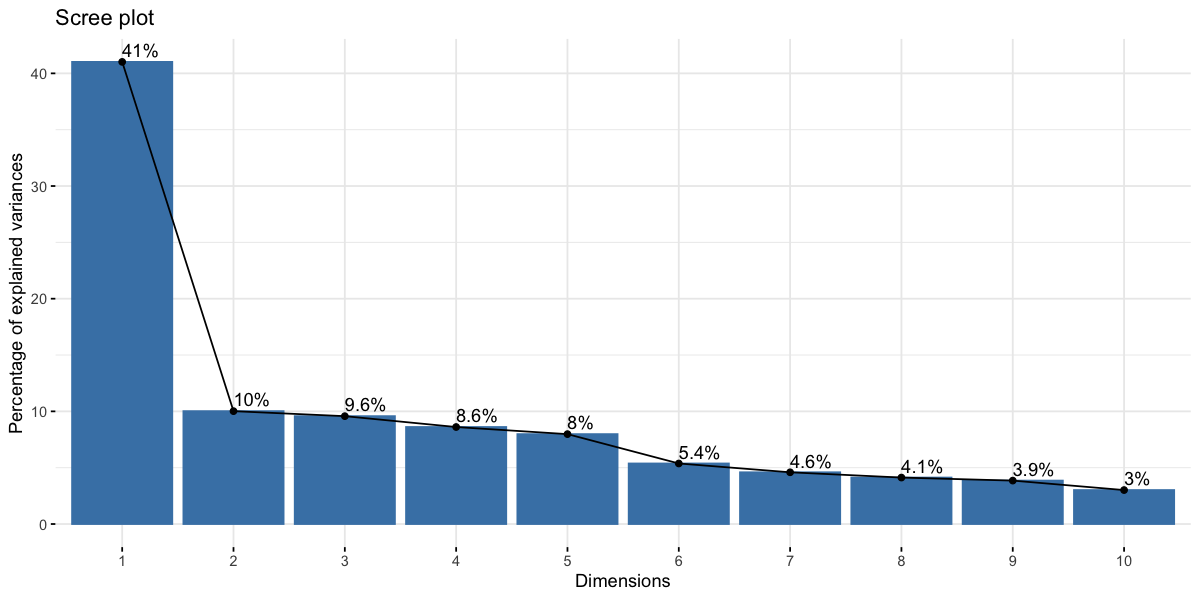

In [12]:
# running PCA
no_outliers_pca_cytokine = prcomp(no_outliers_cytokine_pca_prep_df, scale = TRUE)

# viewing scree plots to see how much of the variance was captured in first 2 eigenvectors
options(repr.plot.width=10, repr.plot.height=5) #changing size
fviz_eig(no_outliers_pca_cytokine, addlabels = TRUE)

Warning message:
“ggrepel: 31 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


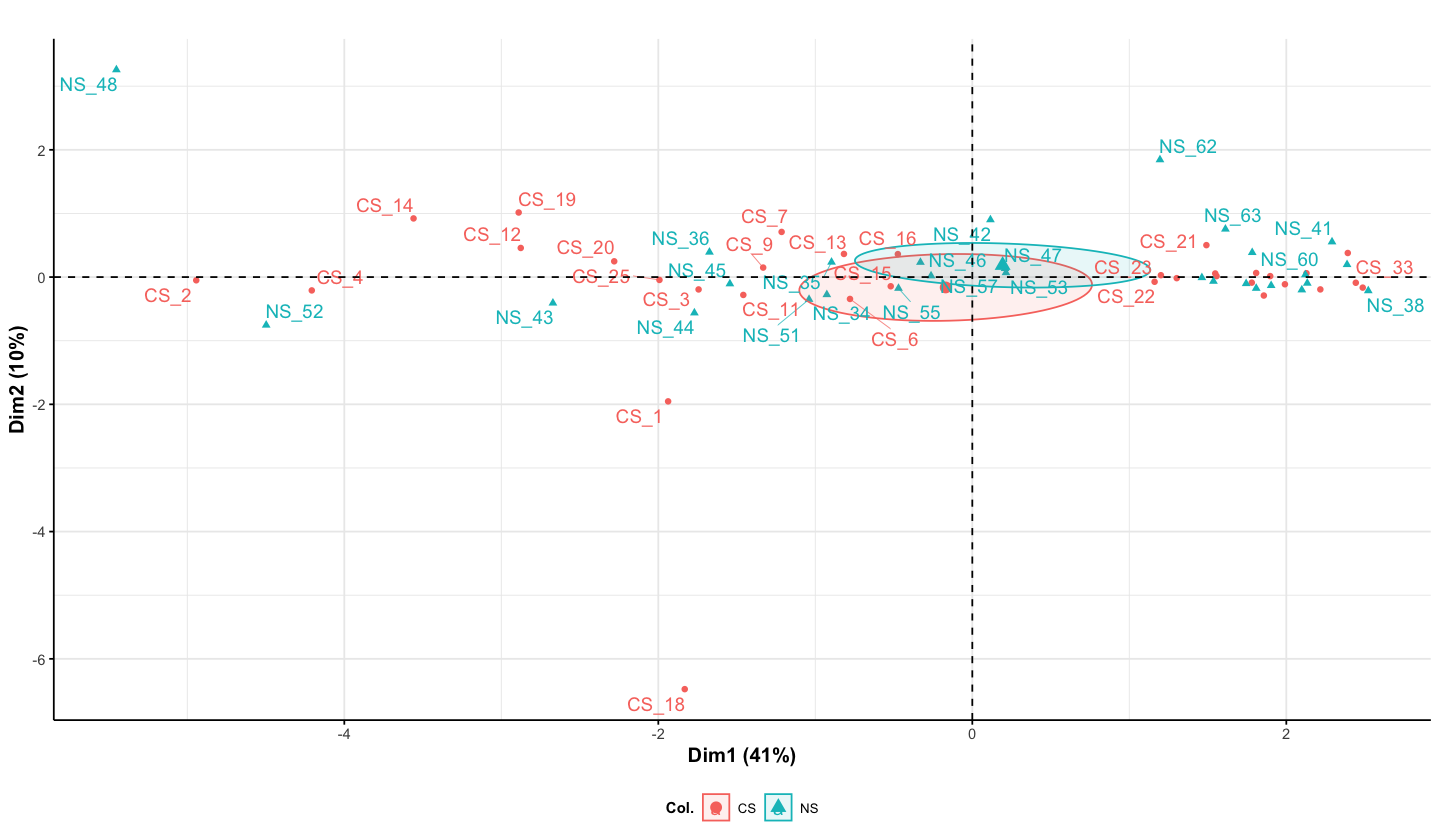

In [13]:
# visualizing all data to detect outlier subjects
options(repr.plot.width=12, repr.plot.height=7) #changing size
fviz_pca_ind(no_outliers_pca_cytokine, 
             col.ind = no_outliers_cytokine_df$Group, # color by Group
             #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.title = element_text(size = 9, face = "bold"),
      legend.text = element_text(size = 8),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.1))) #changes axis titles

Quantifying each variable's weighted contribution to principal components by looking at loadings. Only looking at first principal component, since it captures a significantly larger portion of the variance.

In [36]:
#looking at loadings
#trying to see what food categories have high loadings for a PC (what principal components are driven by what food groups?)
loadings = data.frame(pca_cytokine$rotation) %>%
  rownames_to_column(var = "Cytokine") %>%
  select(Cytokine, PC1, PC2) %>%
  pivot_longer(cols = c("PC1", "PC2"), names_to = "PC", values_to = "Loading") %>%
  # adding an additional bogus col for the later heat map to work
  mutate(Category = "Cytokine")

head(loadings)

Cytokine,PC,Loading,Category
<chr>,<chr>,<dbl>,<chr>
IP10,PC1,0.11935233,Cytokine
IP10,PC2,0.15204544,Cytokine
IFNg,PC1,-0.38392525,Cytokine
IFNg,PC2,0.06593253,Cytokine
IL10,PC1,-0.17712657,Cytokine
IL10,PC2,0.66374175,Cytokine


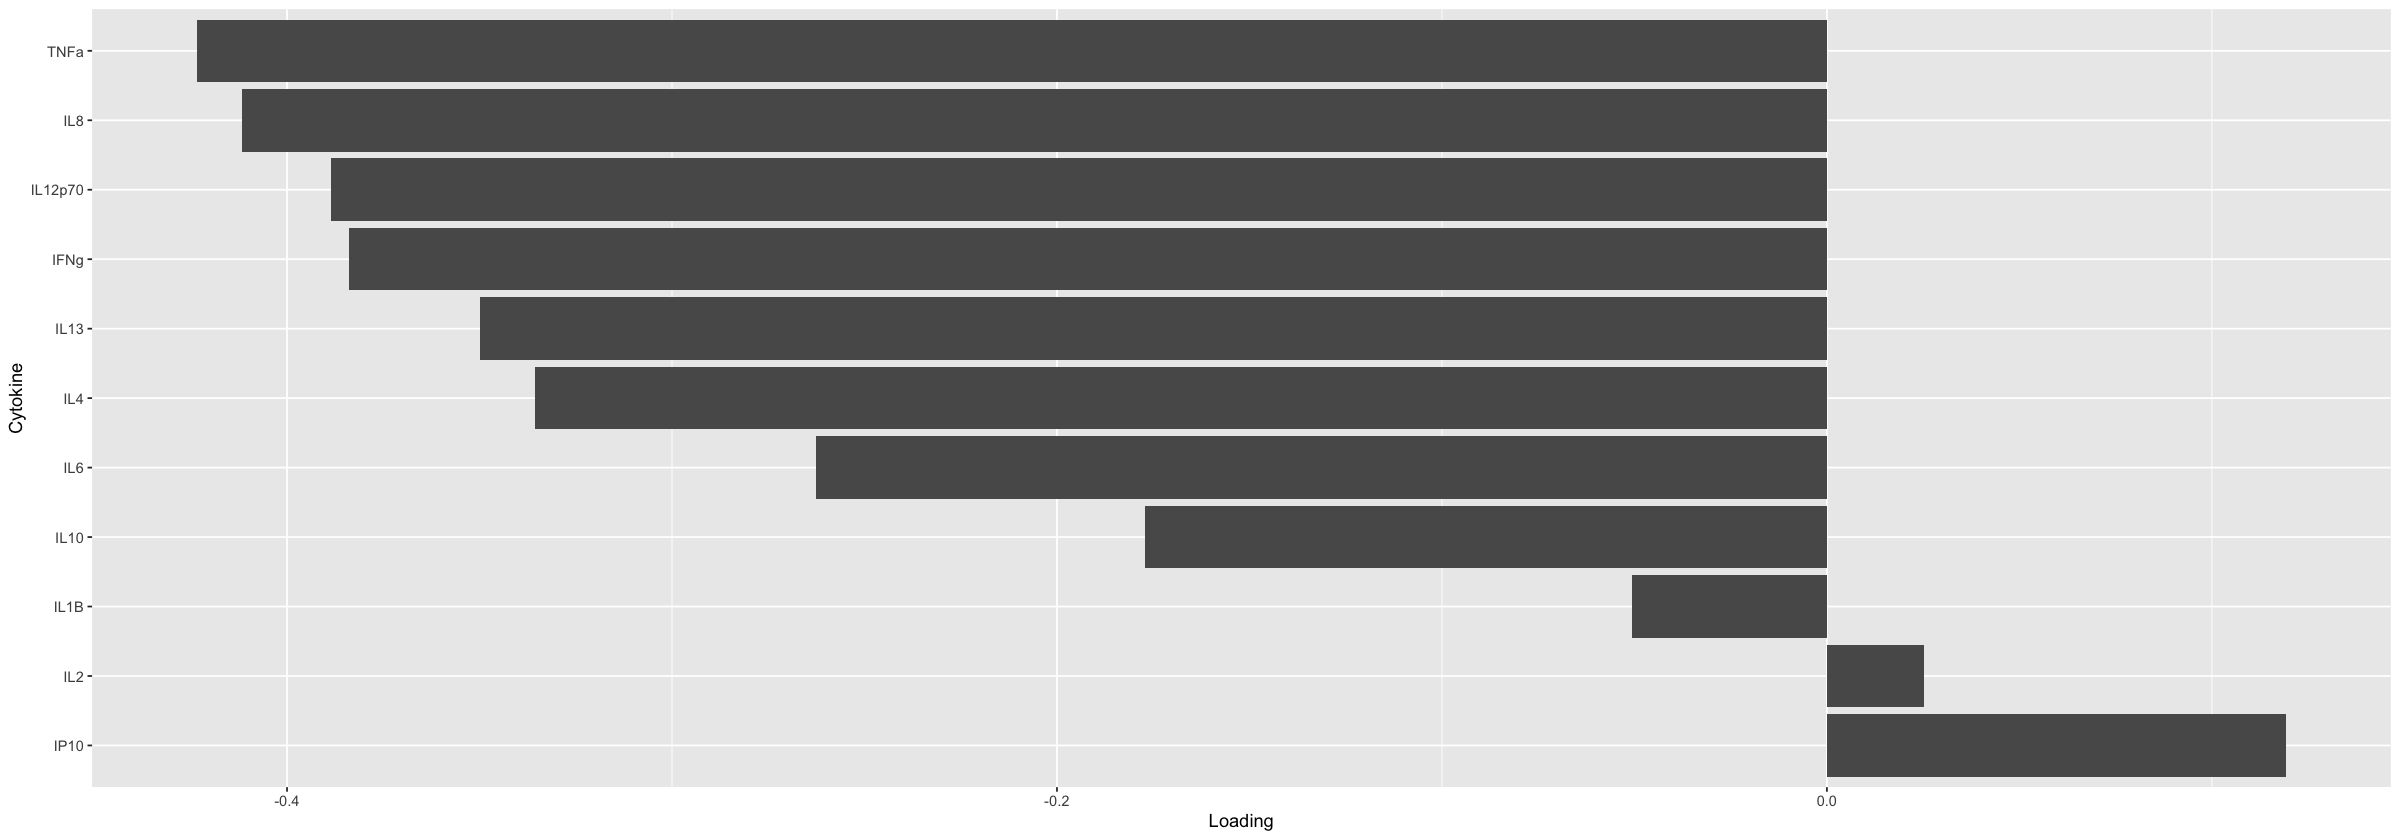

In [37]:
ggplot(loadings %>%
         #filtering for PC1
         filter(PC == "PC1"), 
       aes(y = reorder(Cytokine, -Loading), x = Loading)) + 
  geom_bar(stat = "identity") + 
  #facet_wrap(~PC, ncol = 1, scales = 'free_y') 
  ylab("Cytokine")

Now determining if the loading values are correlated with the concentrations.

In [38]:
# creating a df just for the heat map
heat_map_df = allostatic_loading_df %>%
    filter(Category == "Cytokine", Subject_ID != "NS_61") %>%
    mutate(Conc_pslog2 = log2(Value + 1))

In [39]:
# obtaining ordered avg cytokine concentrations
ordered_df = heat_map_df %>%
    group_by(Variable) %>%
    summarize(Avg_Conc = mean(Conc_pslog2)) %>%
    arrange(Avg_Conc)

ordered_avg_cytokines = ordered_df$Variable
ordered_avg_cytokines

# putting df col into factors
heat_map_df$Variable = factor(heat_map_df$Variable, levels = ordered_avg_cytokines)

[1] "IL4"     "IL1B"    "IL10"    "IL6"     "TNFa"    "IFNg"    "IL8"    
 [8] "IP10"    "IL12p70" "IL13"    "IL2"

In [40]:
#getting subject id's ordered by avg concentrations
# ordering by Group first
heat_map_df$Group = factor(heat_map_df$Group, levels = c("NS", "CS"))
ordered_df = heat_map_df %>%
    group_by(Group, Subject_ID) %>%
    summarize(Avg_Conc = mean(Conc_pslog2)) %>%
    arrange(Group, Avg_Conc)

ordered_avg_subject_ids = ordered_df$Subject_ID
ordered_avg_subject_ids

# putting df cols into factors
heat_map_df$Subject_ID = factor(heat_map_df$Subject_ID, levels = ordered_avg_subject_ids)

`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


[1] "NS_54" "NS_47" "NS_40" "NS_46" "NS_56" "NS_39" "NS_37" "NS_59" "NS_58"
[10] "NS_38" "NS_36" "NS_35" "NS_49" "NS_53" "NS_57" "NS_50" "NS_41" "NS_55"
[19] "NS_45" "NS_60" "NS_34" "NS_51" "NS_62" "NS_42" "NS_44" "NS_63" "NS_43"
[28] "NS_48" "NS_52" "CS_10" "CS_28" "CS_27" "CS_26" "CS_31" "CS_29" "CS_8" 
[37] "CS_33" "CS_17" "CS_14" "CS_24" "CS_23" "CS_30" "CS_16" "CS_5"  "CS_22"
[46] "CS_21" "CS_32" "CS_6"  "CS_15" "CS_13" "CS_3"  "CS_1"  "CS_9"  "CS_19"
[55] "CS_20" "CS_2"  "CS_4"  "CS_18" "CS_25" "CS_11" "CS_7"  "CS_12"

In [41]:
head(heat_map_df)

,Study,Original_Subject_Number,Subject_Number,Group,Subject_ID,Sex,Age,Race,Category,Variable,Value,Conc_pslog2
,<chr>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>
1,FM2,97,1,CS,CS_1,M,18,B,Cytokine,IP10,0.0990,0.1361914
2,FM2,99,2,CS,CS_2,F,20,W,Cytokine,IP10,0.3560,0.4393572
3,FM2,101,3,CS,CS_3,F,20,W,Cytokine,IP10,0.2140,0.2797684
4,FM2,98,4,CS,CS_4,F,21,W,Cytokine,IP10,0.0840,0.1163648
5,TCORS LAIV,39,5,CS,CS_5,M,21,W,Cytokine,IP10,123.0310,6.9545569
6,FM2,100,6,CS,CS_6,F,22,W,Cytokine,IP10,0.1075,0.1473067


[1] "#FC8D59" "#FFFFBF" "#91BFDB"

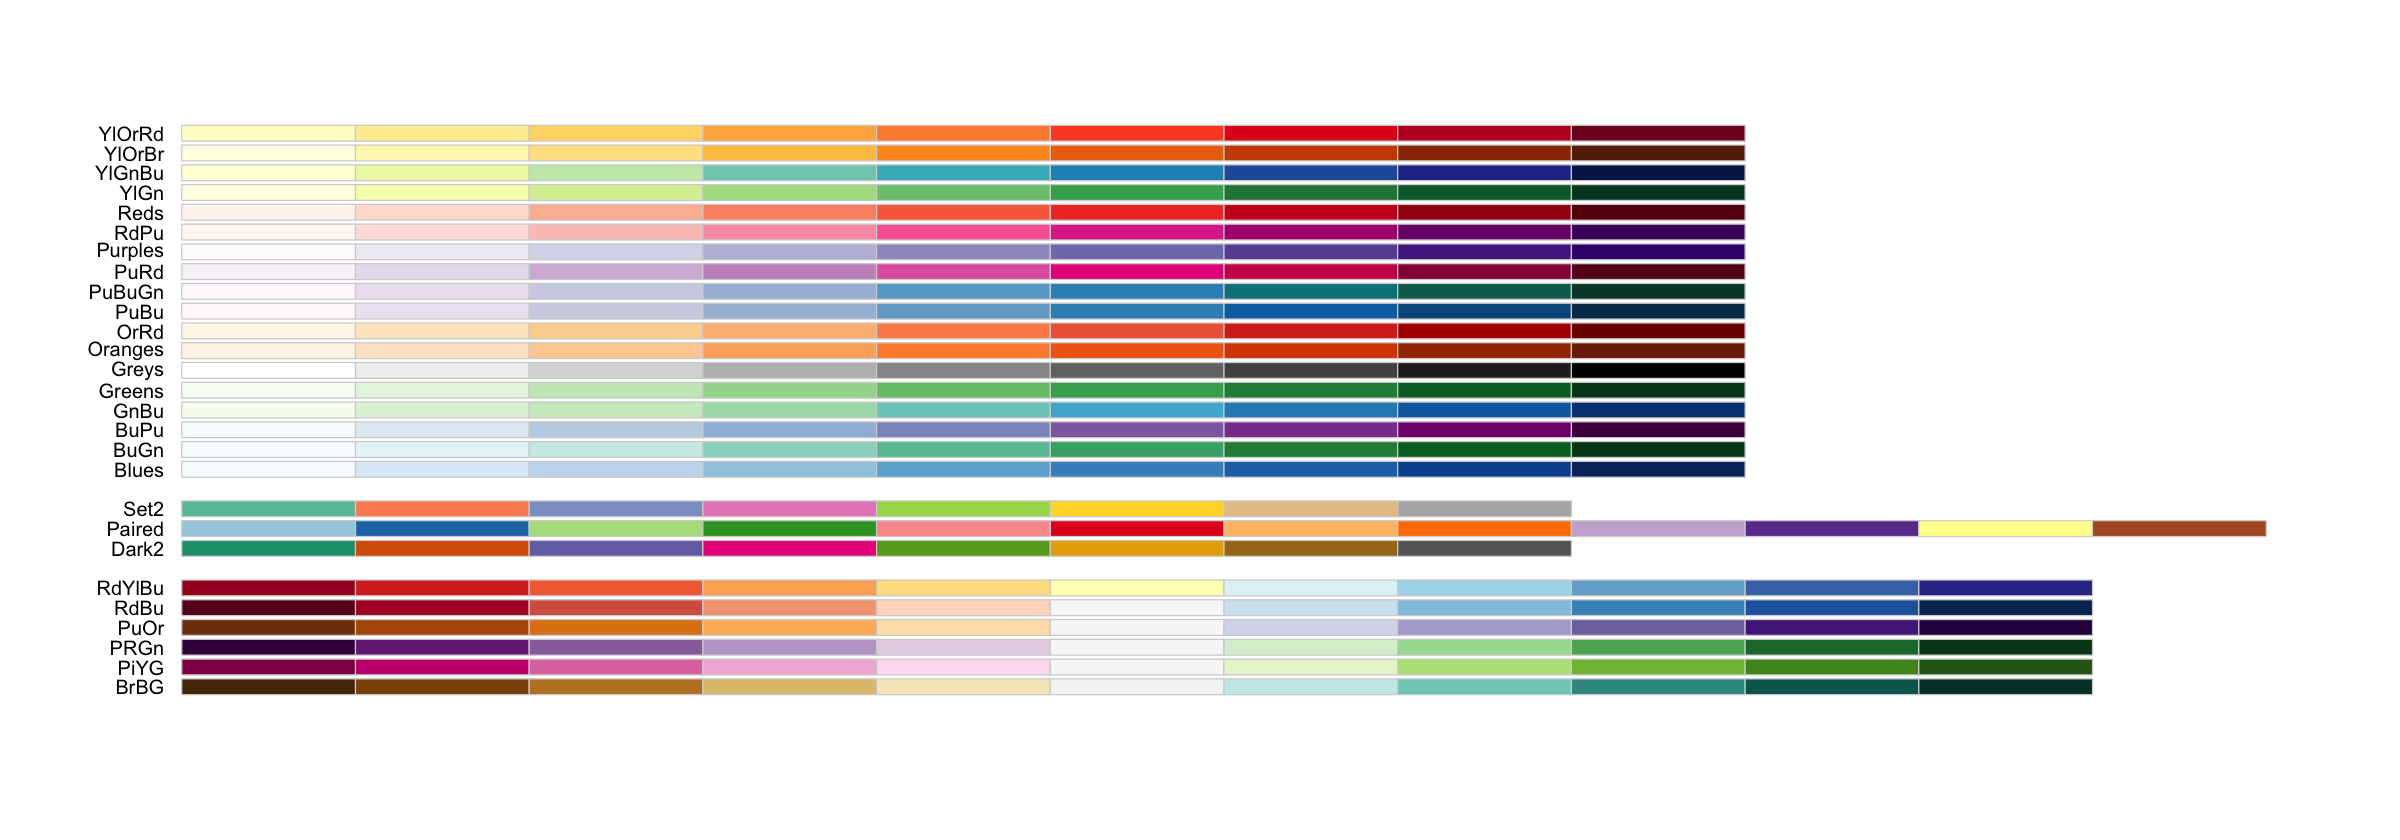

In [42]:
display.brewer.all(colorblindFriendly = TRUE)
brewer.pal(3, "RdYlBu")

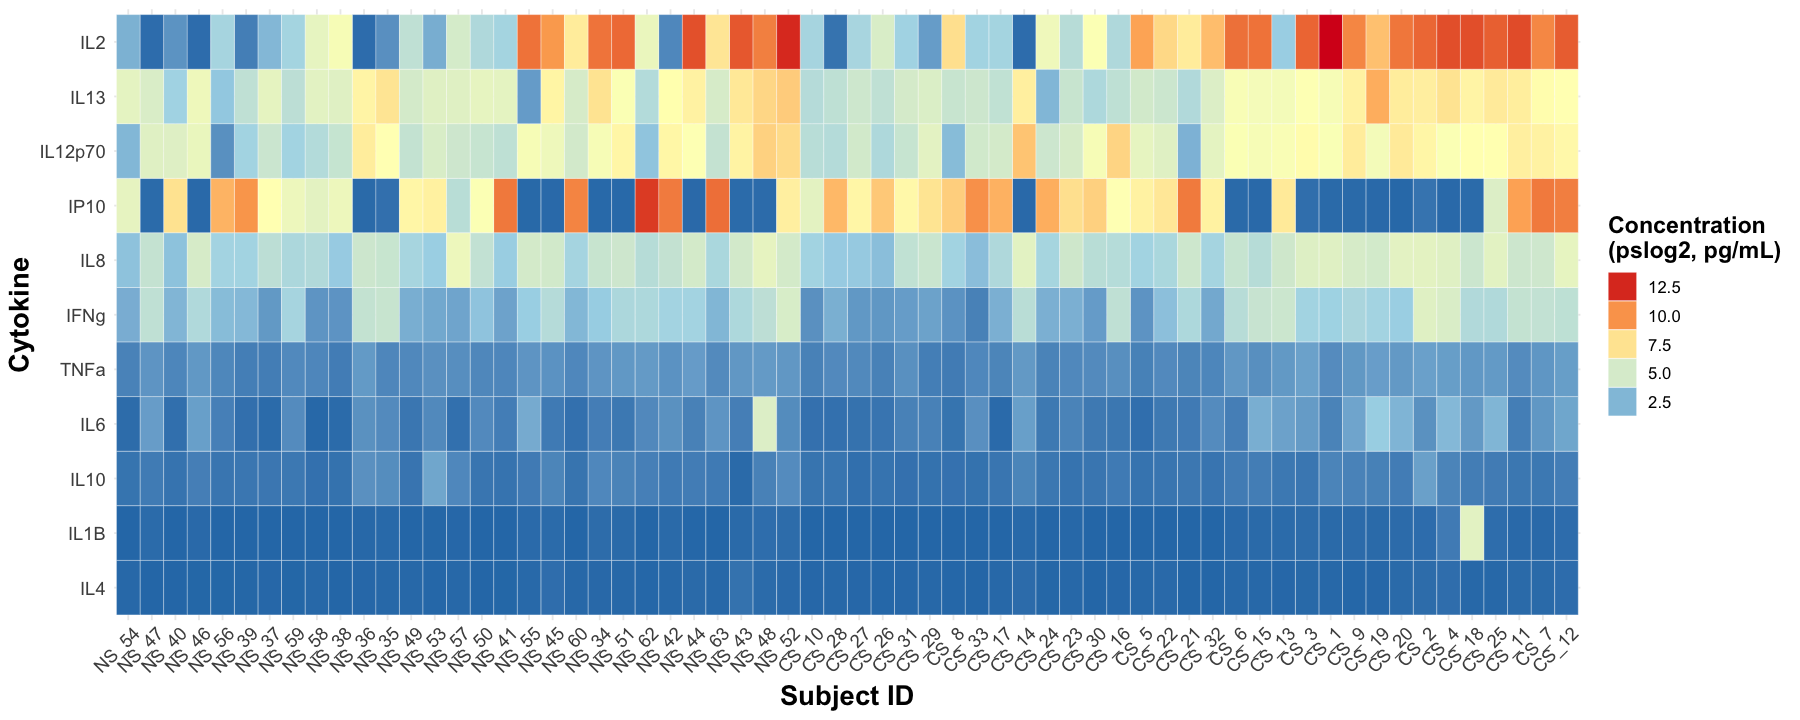

In [43]:
options(repr.plot.width=15, repr.plot.height=6) #changing size
conc_heat_map = ggplot(data = heat_map_df) +
  geom_tile(aes(x = Subject_ID, y = Variable, fill = Conc_pslog2), color = "white") + 

  theme_minimal() +
  theme(axis.text = element_text(size = 11), #changing size of axes labels
        axis.text.x = element_text(angle = 45, hjust = 0.9), #rotating x labels/ moving x labels slightly to the left
        axis.title = element_text(face = "bold", size = rel(1.5)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 10)) + #changes legend text

  labs(x = "Subject ID", y = "Cytokine", fill = "Concentration\n(pslog2, pg/mL)") + 
  guides(fill = guide_legend(reverse = TRUE)) + 
  scale_fill_gradientn(colors = brewer.pal(5, "RdYlBu"), trans = "reverse") 

conc_heat_map

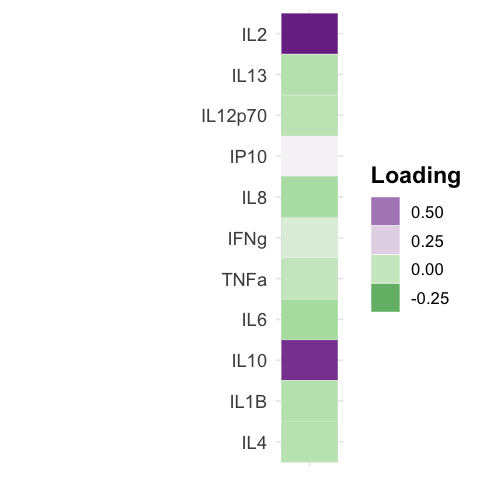

In [51]:
options(repr.plot.width=4, repr.plot.height=4) #changing size

# putting into a factor 
loadings$Cytokine = factor(loadings$Cytokine, levels = ordered_avg_cytokines)

loading_heat_map = ggplot(data = loadings, aes(x = Category, y = Cytokine, fill = Loading)) + 
  geom_tile() + 
  geom_tile(color = "white") + 
  theme_minimal() + 
  theme(axis.text = element_text(size = 11), #changing size of x axis labels
        axis.title.y = element_text(face = "bold", size = rel(1.5), color = 'white', 
                                    #this will create more space between the two graphs in patchwork
                                    margin = margin(r = 100)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 10), #changes legend text
        axis.text.x = element_blank(), # removes x axis text
        axis.ticks.x = element_blank(), #removes x axis ticks
        axis.title.x = element_blank()) + #removes x axis title

  scale_fill_gradientn(colors = brewer.pal(5, "PRGn"), trans = "reverse") + 
  guides(fill = guide_legend(reverse = TRUE)) 
                     
loading_heat_map

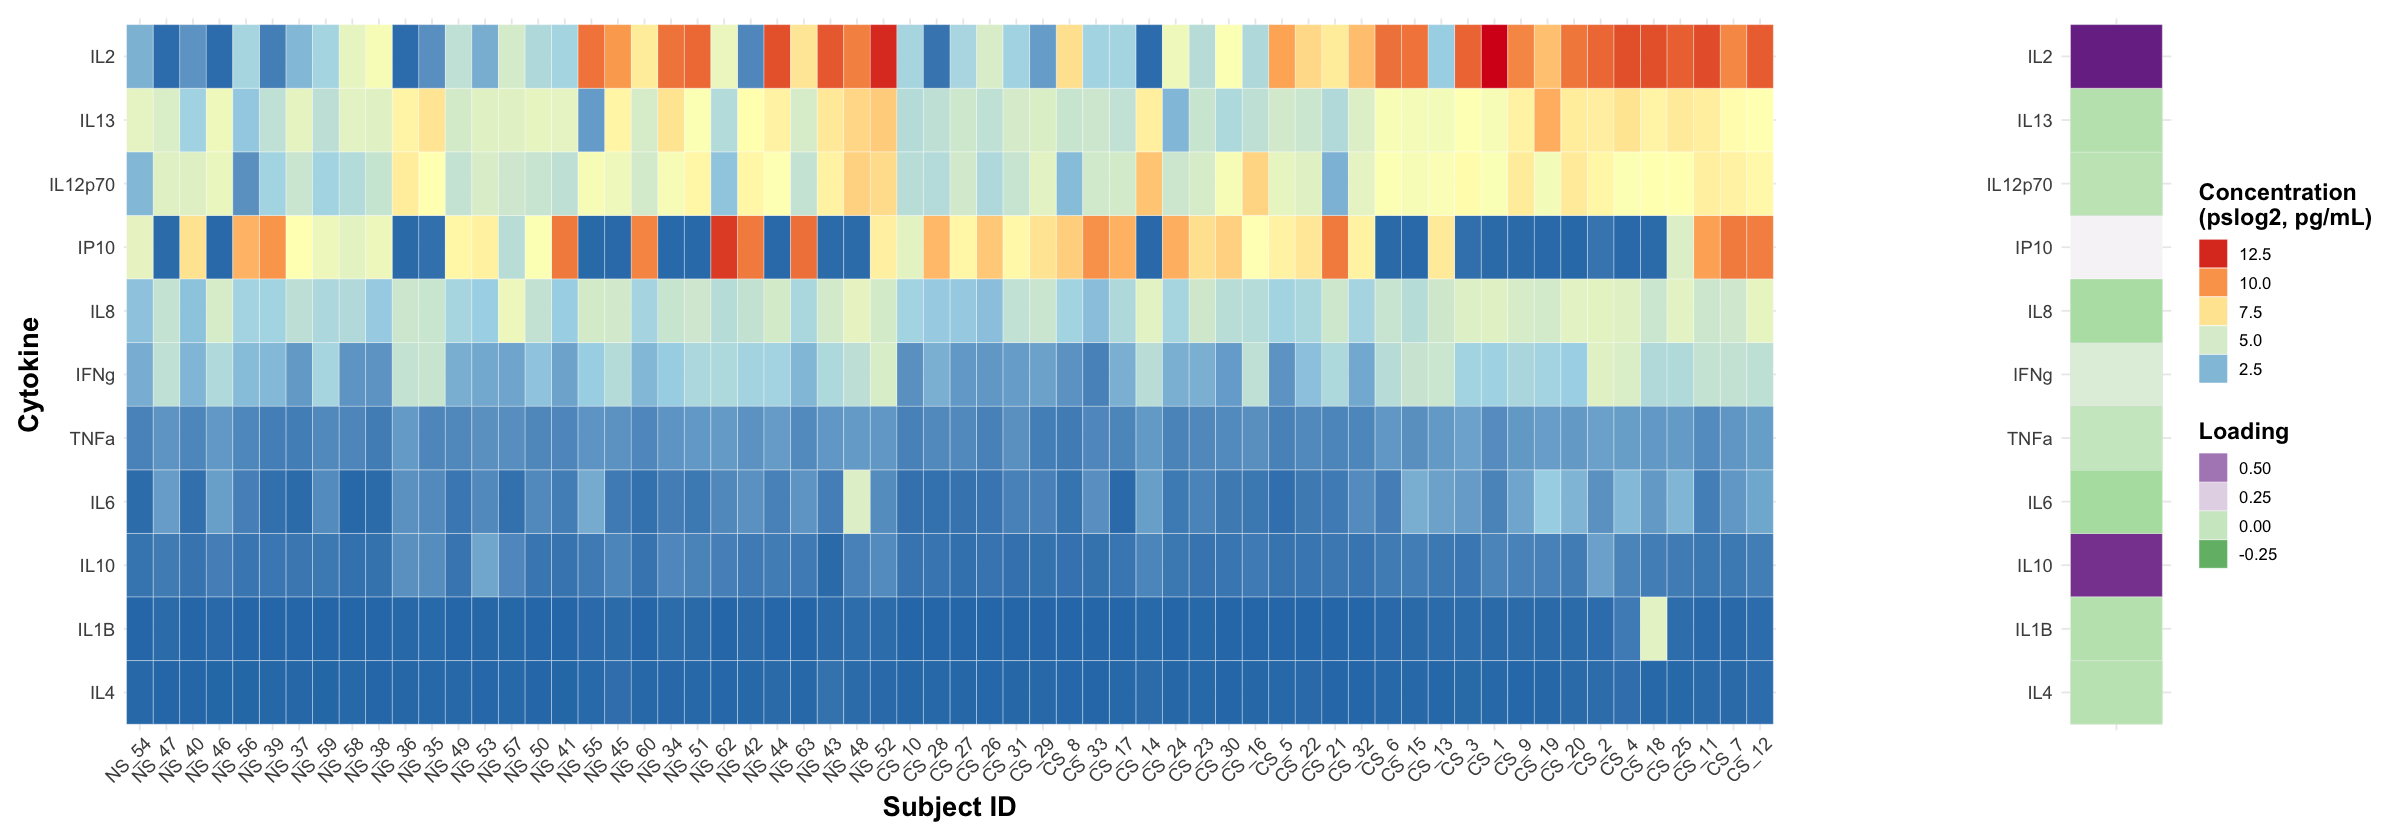

In [52]:
options(repr.plot.width=20, repr.plot.height=7) #changing size
conc_heat_map + loading_heat_map + plot_layout(width = c(15, 1), guides = "collect")